## Final Project: Aya Eid
In this code, I load in data containing xyk spectral volumes of data with labels of defining if a pixel is within a nucleus or not. As it was entirely written by hand (no skikitlearn) and before I learned about NN/batch processing, there was limited computaional resources for training.  

In [50]:
from __future__ import division
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import random
import warnings
import pylab
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold


"""%matplotlib notebook"""
warnings.filterwarnings('ignore')

First a simple data loading function.

In [51]:
# load data
def load_data(filename):
    data = np.array(np.genfromtxt(filename, delimiter=','))  
    x = data[:,:-1]
    y = np.reshape(data[:,-1],(np.size(data[:,-1]),1))
    return x,y

Helper functions

In [52]:
def poly_features_multiDim(x,D):
    """generates polynomial features with orders ranging from 0->D"""   
    poly = PolynomialFeatures(D)
    F = poly.fit_transform(x)  
    return F.T

def fourier_features(x,D):
    """takes fourier coefficients"""
    x.shape = (x.size,1)
    F = np.zeros((2*D+1, x.size))    
    F[0,:] = np.ones((1,x.size))      
    for i in np.arange(1,D+1):        
        F[2*i-1,:] = np.cos(2*np.pi*x*i).flatten()
        F[2*i,:] = np.sin(2*np.pi*x*i).flatten()         
    return F

def softmax_grad(F,y,w,nIter):
    """gradient of softmax cost function"""
    alpha = 10**-2 
    for k in range(nIter): 
        r = np.zeros((F.shape[1],1))
        for p in range(y.shape[0]):
            r = r + -1 * sigmoid(-y[p] * (F.T @ w)) * y[p]
        grad = F @ r     
        w = w - alpha * grad
    return w

def sigmoid(t):
    """sigmoid activation function """
    return 1/(1 + np.exp(-t))

def partition_indices(length, n):
    indices = np.arange(length)
    np.random.shuffle(indices)
    q, r = divmod(length, n)
    stIndices = [q*i + min(i, r) for i in range(n+1)]
    return [indices[stIndices[i]:stIndices[i+1]] for i in range(n)]  

def partition_indices_better(x, y, k):
    kf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    return [test_index for test_index, test_index in kf.split(x, y)]  
 
def get_classification_res(yTrue, yPredicted):  
    TP = np.logical_and(yTrue, yPredicted)
    TN = np.logical_and(np.logical_not(yTrue), np.logical_not(yPredicted))
    FP = np.logical_and(np.logical_not(yTrue), yPredicted)
    FN = np.logical_and(yTrue, np.logical_not(yPredicted))
    return TP, TN, FP, FN

Here I have generated some visualization functions to allow for debugging and testing

In [53]:
# plot the polynomial  
def plot_model_2D(w,D,y,ax,plot_color):
    # plot determined surface in 3d space
    s = np.arange(0, 1, .025)#.025)
    ns = s.size
    
    s.shape = (ns,1)
    sx, sy = np.meshgrid(s,s)
    sx2 = sx.flatten()
    sx2.shape = (sx2.size,1)
    sy2 = sy.flatten()
    sy2.shape = (sy2.size,1)
    s = np.concatenate((sx2,sy2),axis=1)   

    f = poly_features_multiDim(s,D)
    z = np.dot(f.T,w)
    z = np.reshape(z,sx.shape)
    
 
    ax.contour(sx, sy, z, levels=[0])
    plt.axis([-.05,1.05,-.05,1.05])
    #plt.axis([-.1,2,-1,2])
    return ax

def plot_model_3D(ax,w,D,y,plot_color):
    # plot determined surface in 3d space
    s = np.arange(0, 1, .025)
    ns = s.size
    
    s.shape = (ns,1)
    sx, sy, sz = np.meshgrid(s,s,s)
    sx2 = sx.flatten()
    sx2.shape = (sx2.size,1)
    sy2 = sy.flatten()
    sy2.shape = (sy2.size,1)
    sz2 = sz.flatten()
    sz2.shape = (sz2.size,1)
    s = np.concatenate((sx2,sy2,sz2),axis=1)   
    f = poly_features_multiDim(s,D)
    z = np.dot(f.T,w)
    z = np.reshape(z,sx.shape)
 
    verts, faces, _, _ = measure.marching_cubes_lewiner(z, 0, spacing=(0.025, 0.025, 0.025))#spacing=(0.1, 0.1, 0.1))

    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                    color='r', lw=1, alpha = .5)
    return ax

def plot_mse(ax, mses, deg, plot_color, legStr, titStr,xStr):
    plt.figure(figsize = (15,15))
    plt.sca(ax)
    plt.plot(deg,mses,'--^', color = plot_color, label=legStr)
    plt.title(titStr, fontsize=28)
    plt.xlabel(xStr, fontsize=28)
    plt.ylabel('error', fontsize=28)
    plt.xlabel('degree D', fontsize=28)
            
# plot data 
def plot_data(x,y,i,plot_color, grid):
    plt.subplot(grid[int(np.floor(i/3)), (i % 3) ])
    plt.scatter(x,y,s = 30, color = plot_color)
    plt.axis([-.1,1.1,-.1,1.1])
    s = 'Hold out #' + str(i)
    plt.title(s, fontsize=15)


Here we train the model.  Using polynomial feature bases, I first find the optimal number of features using 10 fold hold out validation.

In [54]:
# run over all the degrees, fit each models, and calculate errors
def hold_out_validation(x, y, k, deg_range, is_train):  
    nP = x.shape[0]
    is_in = y == 1
    is_out = np.logical_not(is_in)
    
    
    indices = partition_indices_better(x,y,k)
    
    color_test = 'orange'    
    color_train = 'blue'
    fig = plt.figure(figsize = (16,16))#20))
    ax = fig.add_subplot(111)     

    mses_test = np.zeros((deg_range.size,1))
    mses_train = np.zeros((deg_range.size,1))
    

    is_test = np.logical_not(is_train)  

    yTrain = y[is_train]
    yTest  = y[is_test]

    for D in np.arange(0,np.size(deg_range)):
        # print(D/np.size(deg_range))  # -> pseudo progress bar
        # First we find the optimal number of features for this training set  

        F_train = poly_features_multiDim(x[is_train,:], deg_range[D])                
        F_test  = poly_features_multiDim(x[is_test,:], deg_range[D])   

        temp = np.linalg.pinv(np.dot(F_train, F_train.T))             
        w = np.dot(np.dot(temp, F_train),yTrain) 

        trainMSEtemp = np.sign(-yTrain * np.dot(F_train.T, w))
        trainMSEtemp[trainMSEtemp < 0] = 0

        testMSEtemp = np.sign(-yTest * np.dot(F_test.T, w))
        testMSEtemp[testMSEtemp < 0] = 0

        mses_train[D] = np.sum(trainMSEtemp)/trainMSEtemp.shape[0]
        mses_test[D] = np.sum(testMSEtemp)/testMSEtemp.shape[0]

    # choose best case number of features and plot the final model
    deg_final = 8 # deg_range[np.argmin(mses_test)]   
    F_train = poly_features_multiDim(x[is_train,:], deg_final) 
    F_test  = poly_features_multiDim(x[is_test,:], deg_final)   
    F = poly_features_multiDim(x, deg_final)
    temp = np.linalg.pinv(np.dot(F_train, F_train.T))             
    w_Final = np.dot(np.dot(temp, F_train), yTrain)      

    plot_mse(ax, mses_test, deg_range, color_test, 'Testing Error','','')
    plot_mse(ax, mses_train, deg_range, color_train, 'Training Error', 'Average MSE','degree D')
    plt.legend(fontsize=25)

    mse_all_final = np.sign(-y * np.dot(F.T, w_Final))
    mse_all_final[mse_all_final < 0] = 0
    
    print('Optimal dgree chosen to be: ', deg_final)
    return  mse_all_final, deg_final

Load data, train for varying polynomial degrees, choose a model

Optimal dgree chosen to be:  8


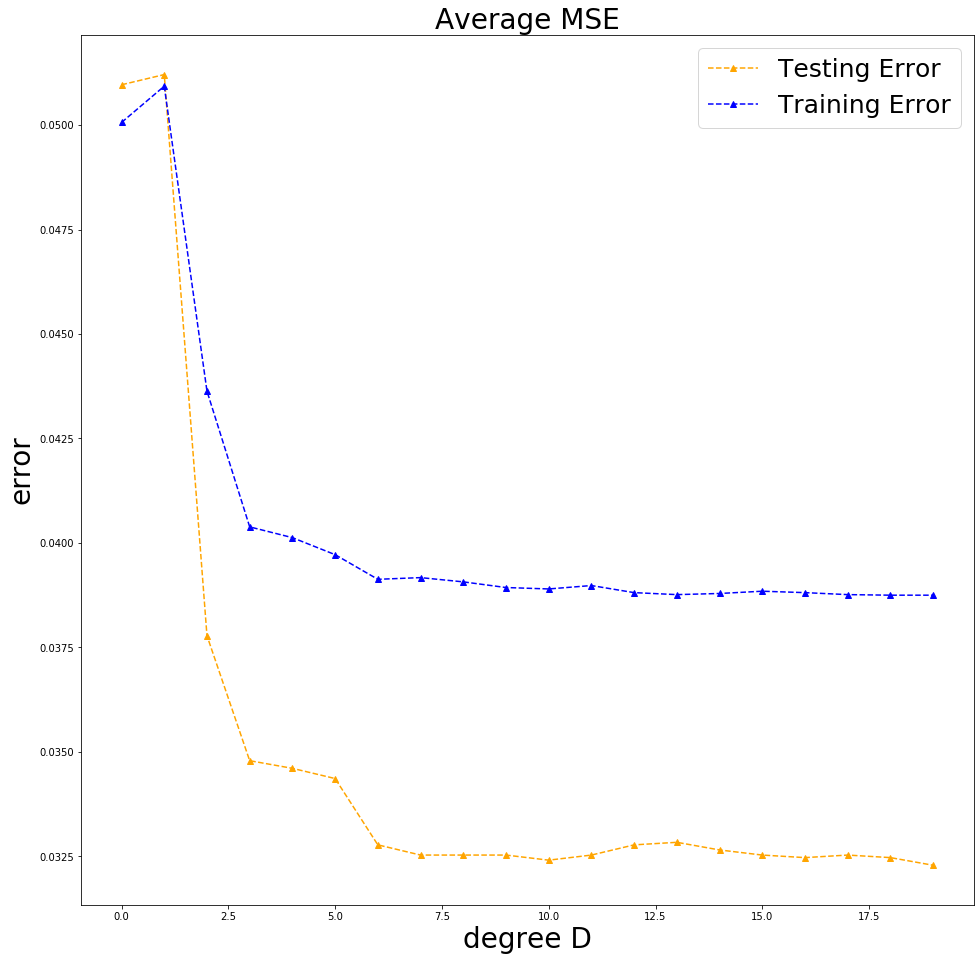

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [55]:
# load data and defined degree range  
x, y = load_data('data_dn4_3d\DATA_W1_downsampled.csv')

# randomy load in each image and concatenate it to the data list
nImg = 1;
imgNum = np.arange(2,11); 
random.shuffle(imgNum)
imgNums = np.ones((y.shape));
for i in imgNum:
    nImg += 1    
    xT, yT = load_data('data_dn4_3d\DATA_W' + str(i) + '_downsampled.csv')
    imgNums = np.concatenate((imgNums, i * np.ones((yT.shape))),axis=0);
    x = np.concatenate((x,xT),axis=0);
    y =  np.concatenate((y,yT),axis=0)

# rescale all data from 0 to 1
for i in range(x.shape[1]):
    x[:,i] = (x[:,i] - np.min(x[:,i]))/np.ptp(x[:,i])

# deciding if it the data is for training or or testing (not the best way)
is_train = np.zeros(x.shape[0], dtype=bool)
is_train[0:-np.int(x.shape[0]/nImg)] = True
is_test = np.logical_not(is_train)

# setting classification output to be 1 or -1
y[y==0] = -1; 

# hold out validation
k = 10

# degrees to test
deg_range = np.arange(0,20)  

final_est = hold_out_validation(x, y, k, deg_range, is_train)


In [56]:
PATH = "data_dn4_3d/"

sx, sy = np.meshgrid(np.arange(0,512,4),np.arange(0,512,4))    
sx = sx.flatten()
sy = sy.flatten()

cellTrainToView = 2; 
img1 = mpimg.imread(PATH + "Cell" + str(cellTrainToView) +"_imbd.png")
img2 = mpimg.imread(PATH + "Cell" + str(cellTrainToView) +"_bw.png")

_, yTrained = load_data('data_dn4_3d\DATA_W' + str(cellTrainToView) + '_downsampled.csv')
yTrained_Model = final_est[imgNums==cellTrainToView]
yTrained = yTrained ==1;  yTrained = yTrained.reshape((-1,)) 
yTrained_Model = yTrained_Model == 1; 

TP1, TN1, FP1, FN1 = get_classification_res(yTrained, yTrained_Model)

img3 = mpimg.imread(PATH + "Cell" + str(imgNum[-1]) + "_imbd.png")
img4 = mpimg.imread(PATH + "Cell" + str(imgNum[-1]) + "_bw.png")    
_, yTested = load_data('data_dn4_3d\DATA_W' + str(imgNum[-1]) + '_downsampled.csv')
yTested_Model = final_est[imgNums==imgNum[-1]] 
yTested = yTested ==1;  yTested = yTested.reshape((-1,)) 
yTested_Model = yTested_Model == 1; 

TP2, TN2, FP2, FN2 = get_classification_res(yTested, yTested_Model)


plt.figure(figsize = (34,34))
plt.subplot(221)
plt.imshow(img1); 

plt.subplot(222)
plt.imshow(img2)
plt.plot(sy[TP1],sx[TP1],'g.')
plt.plot(sy[TN1],sx[TN1],'r.')
plt.plot(sy[FP1],sx[FP1],'mx')
plt.plot(sy[FN1],sx[FN1],'mx')


plt.subplot(223)
plt.imshow(img3); 

plt.subplot(224)
plt.imshow(img4)
plt.plot(sy[TP2],sx[TP2], 'g.')
plt.plot(sy[TN2],sx[TN2], 'r.')
plt.plot(sy[FP2],sx[FP2],'mx')
plt.plot(sy[FN2],sx[FN2],'mx')
plt.show()

   
print('--Training Results--')
print('Training Accuracy: ', round((np.sum(TP1)+np.sum(TN1))/yTrained.shape[0],2))
print('Training Precision: (PPV)', round(np.sum(TP1)/(np.sum(TP1) + np.sum(FP1)),2))
print('Training Sensitivity (TPR): ', round(np.sum(TP1)/(np.sum(TP1) + np.sum(FN1)),2))
print('Training Specificity (TNR): ', round(np.sum(TN1)/(np.sum(TN1) + np.sum(FP1)),2))
print('Training Miss Rate (FNR): ', round(np.sum(FN1)/(np.sum(FN1) + np.sum(TP1)),2))
print('F1 score: ', round(np.sum(TP1)/(2*np.sum(TP1) + np.sum(FP1) + np.sum(FN1)),2))
print('\n')

print('TP-train',round(np.sum(TP1)/TP1.shape[0],2))
print('TN-train',round(np.sum(TN1)/TP1.shape[0],2))
print('FP-train',round(np.sum(FP1)/TP1.shape[0],2))
print('FN-train',round(np.sum(FN1)/TP1.shape[0],2))
print('\n')  



print('--Testing Results--')
print('Test Accuracy: ', round((np.sum(TP2)+np.sum(TN2))/yTested.shape[0],2))
print('Test Precision: (PPV)', round(np.sum(TP2)/(np.sum(TP2) + np.sum(FP2)),2))
print('Test Sensitivity (TPR): ', round(np.sum(TP2)/(np.sum(TP2) + np.sum(FN2)),2))
print('Test Specificity (TNR): ', round(np.sum(TN2)/(np.sum(TN2) + np.sum(FP2)),2))
print('Test Miss Rate (FNR): ', round(np.sum(FN2)/(np.sum(FN2) + np.sum(TP2)),2))
print('F1 score: ', round(np.sum(TP2)/(2*np.sum(TP2) + np.sum(FP2) + np.sum(FN2)),2))
print('\n')
    
print('TP-test',round(np.sum(TP2)/TP2.shape[0],2))
print('TN-test',round(np.sum(TN2)/TP2.shape[0],2))
print('FP-test',round(np.sum(FP2)/TP2.shape[0],2))
print('FN-test',round(np.sum(FN2)/TP2.shape[0],2))
print('\n')   


TypeError: only integer scalar arrays can be converted to a scalar index